#### Submission 1: Time Series
# Hourly Energy Consumption Forecasting


By: Diah Ayu Setyaningsih


## Kaggle API configuration

Please upload API token from kaggle (kaggle.json) to colab before run this file.

In [1]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

## Download Dataset

In [2]:
!kaggle datasets download robikscube/hourly-energy-consumption

  0% 0.00/11.4M [00:00<?, ?B/s]
100% 11.4M/11.4M [00:00<00:00, 105MB/s]


In [3]:
!unzip /content/hourly-energy-consumption.zip

Archive:  /content/hourly-energy-consumption.zip
  inflating: AEP_hourly.csv          
  inflating: COMED_hourly.csv        
  inflating: DAYTON_hourly.csv       
  inflating: DEOK_hourly.csv         
  inflating: DOM_hourly.csv          
  inflating: DUQ_hourly.csv          
  inflating: EKPC_hourly.csv         
  inflating: FE_hourly.csv           
  inflating: NI_hourly.csv           
  inflating: PJME_hourly.csv         
  inflating: PJMW_hourly.csv         
  inflating: PJM_Load_hourly.csv     
  inflating: est_hourly.paruqet      
  inflating: pjm_hourly_est.csv      


## Import Module

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

## Import Dataset

This is a dataset of estimated energy consumption in Megawatts (MW) from The Dayton Power and Light Company. This dataset has 121.275 entries from 2004-12-31 01:00:00 to 2018-08-03 00:00:00.


In [5]:
df = pd.read_csv('/content/DAYTON_hourly.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121275 entries, 0 to 121274
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Datetime   121275 non-null  object 
 1   DAYTON_MW  121275 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


## Data Preprocessing

In [6]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.head()

,Datetime,DAYTON_MW
0,2004-12-31 01:00:00,1596.0
1,2004-12-31 02:00:00,1517.0
2,2004-12-31 03:00:00,1486.0
3,2004-12-31 04:00:00,1469.0
4,2004-12-31 05:00:00,1472.0


In [7]:
# sort dataset based on datetime
df.sort_values(by=['Datetime'], inplace=True, ignore_index=True)

In [8]:
# data normalization
scaler = MinMaxScaler()
df['normalized'] = scaler.fit_transform(df['DAYTON_MW'].values.reshape(-1,1))

## Data Exploration

In [9]:
# summary statistics original data
df.DAYTON_MW.describe()

count    121275.000000
mean       2037.851140
std         393.403153
min         982.000000
25%        1749.000000
50%        2009.000000
75%        2279.000000
max        3746.000000
Name: DAYTON_MW, dtype: float64

In [10]:
# summary statistics normalized data
df.normalized.describe()

count    121275.000000
mean          0.382001
std           0.142331
min           0.000000
25%           0.277496
50%           0.371563
75%           0.469247
max           1.000000
Name: normalized, dtype: float64

In [11]:
# 10% range of original data
(df.DAYTON_MW.max() - df.DAYTON_MW.min()) * 0.1

276.40000000000003

In [12]:
# 10% range of normalized data
(df.normalized.max() - df.normalized.min()) * 0.1

0.1

### Visualization

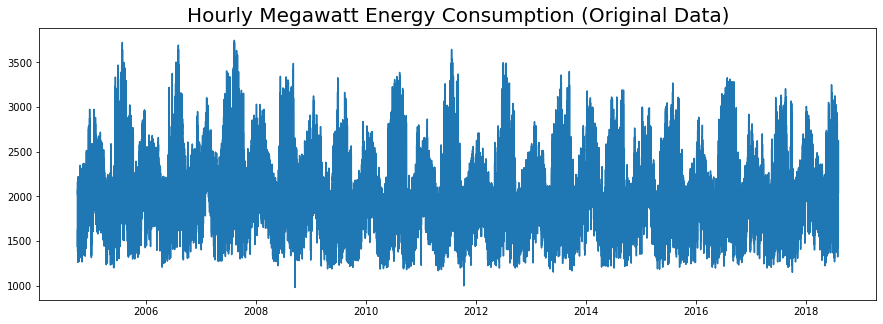

In [13]:
plt.figure(figsize=(15,5))
plt.plot(df['Datetime'], df['DAYTON_MW'])
plt.title('Hourly Megawatt Energy Consumption (Original Data)', fontsize=20)
plt.show()

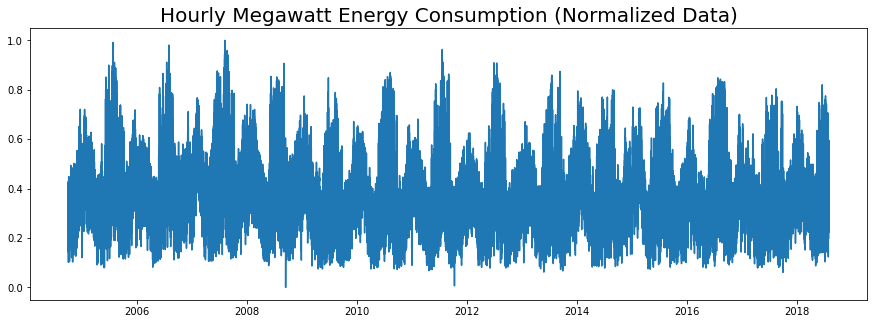

In [14]:
plt.figure(figsize=(15,5))
plt.plot(df['Datetime'], df['normalized'])
plt.title('Hourly Megawatt Energy Consumption (Normalized Data)', fontsize=20)
plt.show()

## Data Preparation

### Split dataset



In [15]:
n_test = round(df.shape[0]*0.2)

date_train = df.Datetime[:-n_test]
x_train = df.normalized[:-n_test]

date_test = df.Datetime[-n_test:]
x_test = df.normalized[-n_test:]

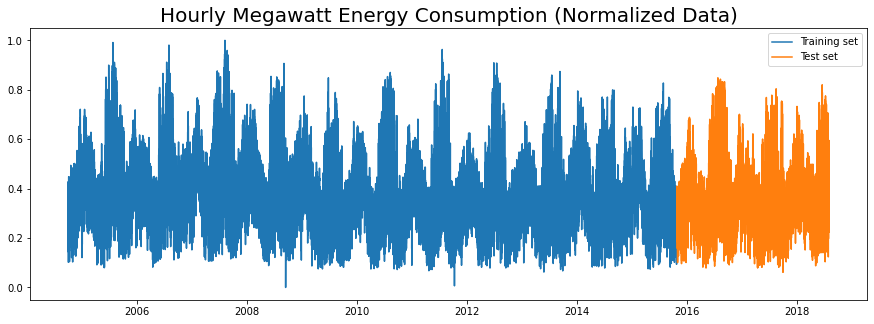

In [16]:
plt.figure(figsize=(15,5))
plt.plot(date_train, x_train)
plt.plot(date_test, x_test)
plt.legend(['Training set', 'Test set'])
plt.title('Hourly Megawatt Energy Consumption (Normalized Data)', fontsize=20)
plt.show()

### Dataset preparation for training


In [17]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """ Devide series into input features and output label that suitable for training model.
    # Arguments
        series = A series.
        window_size = the number of features.
        batch_size = the number of batch size.
        shuffle_buffer =  the number of elements from this dataset from which 
                          the new dataset will sample.
    # Returns
        Features and its label in a batch form.
    """
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size+1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [18]:
shuffle_buffer_size = 100000
window_size = 60
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
test_set = windowed_dataset(x_test, window_size, batch_size, shuffle_buffer_size)

## Create Model

In [19]:
model = tf.keras.models.Sequential([
 tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[window_size, 1]),
 tf.keras.layers.LSTM(32, return_sequences=True),
 tf.keras.layers.LSTM(32, return_sequences=True),
 tf.keras.layers.LSTM(32),
 tf.keras.layers.Dense(64, activation="relu"),
 tf.keras.layers.Dense(32, activation="relu"),
 tf.keras.layers.Dense(1),
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 32)            4352      
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 32)            8320      
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 32)            8320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3

## Callbacks

In [20]:
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, 
                                   mode='auto', verbose=2)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, 
                          mode='auto')
callbacks_list = [reduceLROnPlat, earlystop]

## Training Model

In [21]:
optimizer = tf.keras.optimizers.Adam(lr=1.0000e-04)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, 
                    validation_data=test_set, 
                    epochs=15,
                    callbacks=callbacks_list)

Epoch 1/15
379/379 [==============================] - 10s 27ms/step - loss: 0.0140 - mae: 0.1240 - val_loss: 0.0062 - val_mae: 0.0884
Epoch 2/15
379/379 [==============================] - 9s 25ms/step - loss: 0.0067 - mae: 0.0927 - val_loss: 0.0061 - val_mae: 0.0873
Epoch 3/15
379/379 [==============================] - 9s 23ms/step - loss: 0.0064 - mae: 0.0901 - val_loss: 0.0050 - val_mae: 0.0792
Epoch 4/15
379/379 [==============================] - 9s 24ms/step - loss: 0.0034 - mae: 0.0649 - val_loss: 0.0025 - val_mae: 0.0556
Epoch 5/15
379/379 [==============================] - 9s 23ms/step - loss: 0.0025 - mae: 0.0551 - val_loss: 0.0020 - val_mae: 0.0489
Epoch 6/15
379/379 [==============================] - 10s 25ms/step - loss: 0.0019 - mae: 0.0473 - val_loss: 0.0016 - val_mae: 0.0437
Epoch 7/15
379/379 [==============================] - 9s 25ms/step - loss: 0.0015 - mae: 0.0418 - val_loss: 0.0013 - val_mae: 0.0391
Epoch 8/15
379/379 [==============================] - 9s 24ms/step 

## Plot Training History

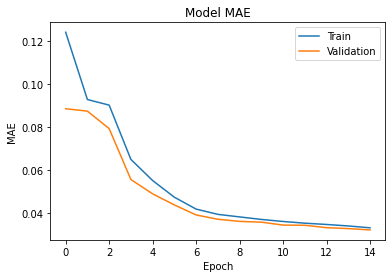

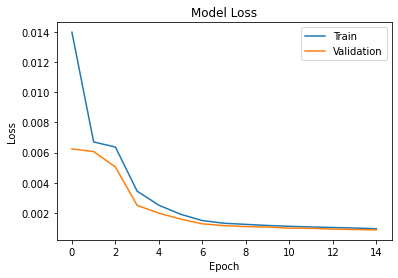

In [22]:
#  "MAE"
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

## Forecast

In [23]:
def model_forecast(model, series, window_size):
    """ Forecast the (window_size+1)-th period to (length series+1)-th period from the series.
    # Arguments
        model = a model that had been trained.
        series = a series.
        window_size = the number of features.
    # Returns
        Forecast result.
    """
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [24]:
normalized_forecast = model_forecast(model, df.normalized[-(n_test+60):], 60)

In [25]:
original_forecast = scaler.inverse_transform(normalized_forecast)

### Forecast visualization on original test dataset




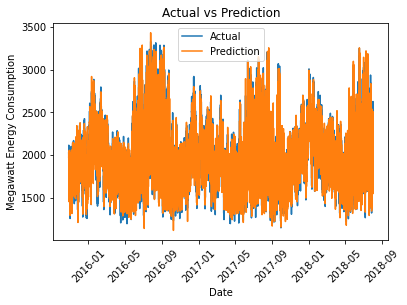

In [26]:
plt.plot(date_test,df.DAYTON_MW[-(n_test):])
plt.plot(date_test,original_forecast[:-1])
plt.xticks(rotation=45)
plt.title('Actual vs Prediction')
plt.ylabel('Megawatt Energy Consumption')
plt.xlabel('Date')
plt.legend(['Actual', 'Prediction'])
plt.show()

### MAE on original test dataset

In [27]:
mae_test = mean_absolute_error( df.DAYTON_MW[-(n_test):], original_forecast[:-1])
print('Test MAE: %.3f' % mae_test)

Test MAE: 88.719


### Forecast for next period


In [28]:
df.tail()

,Datetime,DAYTON_MW,normalized
121270,2018-08-02 20:00:00,2554.0,0.568741
121271,2018-08-02 21:00:00,2481.0,0.542330
121272,2018-08-02 22:00:00,2405.0,0.514834
121273,2018-08-02 23:00:00,2250.0,0.458755
121274,2018-08-03 00:00:00,2042.0,0.383502


In [29]:
print('Forecast for 2018-08-03 01:00:00 is %.0f' % original_forecast[-1])

Forecast for 2018-08-03 01:00:00 is 1974
